In [2]:
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

from ur5e import ur_custom_casadi as ur_kin
import pybullet.mpc_controller as mpc
import utils.reference as ref
import utils.human_motion as hum_motion
from ur5e import ur_custom
from utils.kalman_filter_3d import KalmanFilter3D

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

# Construct a controller

In [9]:
root_config = r"C:\Users\kawaw\python\mpc\casadi_mpc_nyuumon\src\pybullet\config"

config_env = os.path.join(root_config, "env", "mpc.yaml")
config_policy = os.path.join(root_config, "policy", "mpc.yaml")
mpc_controller = mpc.MPCController(config_env, config_policy)

#solver setting.
mpc_controller.type_solver = "ipopt" #"ipopt","qrsqp", "osqp", "qpoases"
S = mpc_controller.get_solver(mpc_controller.type_solver)


#ur kinematics
ur_kin = ur_custom.UrCustom()

#human motion generator
human = hum_motion.Human()



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Using IPOPT solver


## Make a referential data

length_rope: 3.0


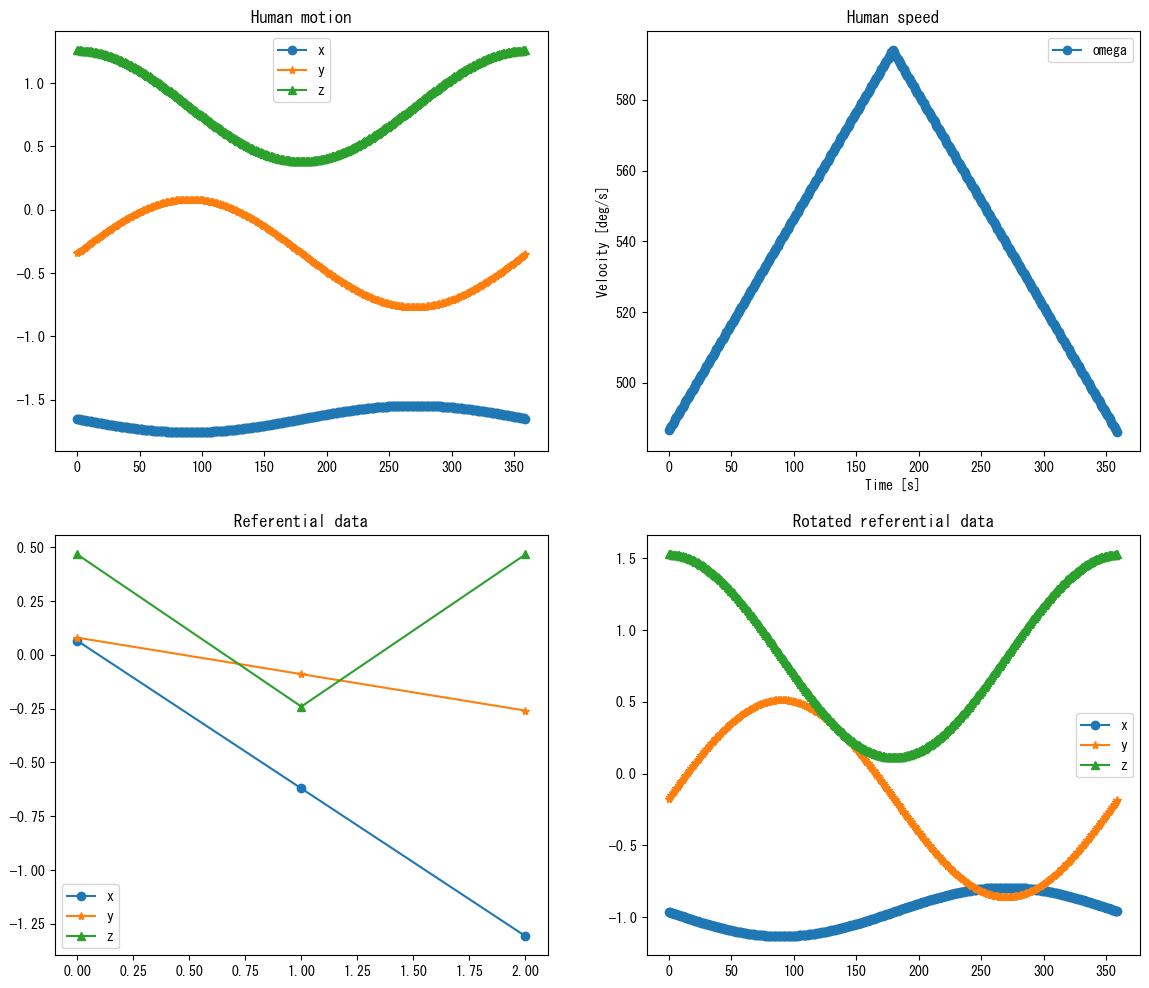

In [10]:
# make a human motion. human motion starts from the 0 degree.
pose_eef = np.array([-0.28, -0.05, 0.704, 0.0, 0.0, 0.0])
joints_list = np.array([-np.pi, -0.314, -np.pi / 2.0, -0.48, np.pi / 2.0, 0.0])  # Example joint angles (radians)
#FK
ur_kin.cal_pose_all(joints_list)
pose_eef = ur_kin.pose6
center_human, samples_human, deg_per_sec_human, vel_samples_turn_human = (
    human.create_motion(pose_eef,rope_length=mpc_controller.length_rope)
)

# update the length of the rope
_length_rope = human.rope_length  # length of the rope
length_rope = human.rope_length
print(f"length_rope: {length_rope}")
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax[0, 0].plot(samples_human[:, 0], linestyle="-", marker="o", label="x")
ax[0, 0].plot(samples_human[:, 1], linestyle="-", marker="*", label="y")
ax[0, 0].plot(samples_human[:, 2], linestyle="-", marker="^", label="z")
ax[0, 0].set_title("Human motion")
ax[0, 0].legend()

ax[0, 1].plot(vel_samples_turn_human, linestyle="-", marker="o", label="omega")
ax[0, 1].set_title("Human speed")
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Velocity [deg/s]")
ax[0, 1].legend()

# create the referential data.
theta_deg_ = 90
x_ref_np, rot_axis = ref.create_referential_data(
    length_rope=_length_rope,
    theta_deg=theta_deg_,
    center_human=center_human,
    pose_eef=pose_eef,
    ns=mpc_controller.ns+1,
)
ax[1, 0].plot(x_ref_np[:, 0], linestyle="-", marker="o", label="x")
ax[1, 0].plot(x_ref_np[:, 1], linestyle="-", marker="*", label="y")
ax[1, 0].plot(x_ref_np[:, 2], linestyle="-", marker="^", label="z")
ax[1, 0].set_title("Referential data")
ax[1, 0].legend()

# Rotate referential data.
x_ref_list = np.zeros((360, mpc_controller.ns+1, 3))  # for 360 points
for i in range(0, 360):
    x_ref_rotates = ref.rotate_referential_data(
        theta_deg=i,
        x_ref=x_ref_np,
        center_human=center_human,
        rot_axis=rot_axis,
    )
    x_ref_list[(180 + i) % 360] = x_ref_rotates.copy()
    # print(f"x_ref_list: {x_ref_list.shape}")
    # x_ref_list[(180 + i) % 360,:, 1:] = -x_ref_list[(180 + i) % 360, :,1:]

ax[1, 1].plot(x_ref_list[:, mpc_controller.ns // 2, 0], linestyle="-", marker="o", label="x")
ax[1, 1].plot(x_ref_list[:, mpc_controller.ns // 2, 1], linestyle="-", marker="*", label="y")
ax[1, 1].plot(x_ref_list[:, mpc_controller.ns // 2, 2], linestyle="-", marker="^", label="z")
ax[1, 1].set_title("Rotated referential data")
ax[1, 1].legend()
plt.show()

## Run simulation

In [ ]:
t_span = [0, 5]  # 3 seconds.
t_eval = np.arange(*t_span, mpc_controller.dt)

#Referential trajectory
x_ref = np.zeros((mpc_controller.K + 1, mpc_controller.nx))  # (K+1,nx)
# Initial referential points.
x_ref[:, : 3 * (mpc_controller.ns+1)] = x_ref_list[: (mpc_controller.K + 1)].reshape(
    (mpc_controller.K + 1), -1
)  # (K+1,ns,3) -> (K+1,ns*3)
#x_ref_total = x_ref.ravel()  # (K+1)*nx
#x_ref_total = x_ref.copy()
x_ref_pos = mpc_controller.get_window_input(x_ref_list, idx_st=0, window_size=mpc_controller.K) #(K+1,ns,3)
x_ref_vel = np.zeros_like(x_ref_pos) #(K+1,ns,3)
x_ref_total = np.concatenate([x_ref_pos, x_ref_vel], axis=1) #(K+1,2*ns,*3)
x_ref_total = x_ref_total.reshape(mpc_controller.K + 1, -1) #(K+1,2*ns*3)
#print(x_ref_total)
print(f"x_ref_total: {x_ref_total.shape}")
#x_ref_total = casadi.DM(x_ref_total)  # Symbolic:(K+1,nx)

#Controller setting.
I = mpc_controller.make_integrator()

#Initial state.
x_init = mpc_controller.make_x_init(pose_eef, samples_human[0], length_rope=length_rope)
offset = 3 * (mpc_controller.ns + 1) #position of the mass points.
x_current = x_init[:,0]
x0 = mpc_controller.make_x0(x_current)

#Storage for the results.
Times_ipopt = []
X = [x_init]
U = []

#Human motion setting.
idx_hum = 0
p_hum_prev = samples_human[0]
##human kf model
kf_hum = KalmanFilter3D(
    initial_x=p_hum_prev[0],
    initial_y=p_hum_prev[1],
    initial_z=p_hum_prev[2],
    initial_vx=0,  # initial_vel[0],
    initial_vy=0,  # initial_vel[1],
    initial_vz=0,  # initial_vel[2],
    initial_ax=0,  # initial_acc[0],
    initial_ay=0,  # initial_acc[1],
    initial_az=0,
    process_noise_pos=1,
    process_noise_vel=1,
    process_noise_acc=1,
    measurement_noise=1,
    dt=mpc_controller.dt,
    measure_velocity=True,  # measure human's velocity.
)

x_hum_pos_list = [p_hum_prev]
x_hum_vel_list = [[0, 0, 0]]
x_hum_acc_list = [[0, 0, 0]]
x_hum_kf_pos_list = [kf_hum.get_position().tolist()]
x_hum_kf_vel_list = [kf_hum.get_velocity().tolist()]
x_hum_kf_acc_list = [kf_hum.get_acceleration().tolist()]
vel_robot = np.zeros(3)

q_robot_list = [joints_list.tolist()]#(6,)
p_robot_list = [pose_eef.tolist()]
for i, t in enumerate(t_eval):
    if i % 10 == 0:
        print(f"t: {t} s/{t_span[1]} s")
    if i > 0:
        """Human's motion update"""
        # for constant velocity.

        deg_step = max(1, int(deg_per_sec_human * mpc_controller.dt))

        # for elaborated velocity.

        deg_step = max(1, int(vel_samples_turn_human[idx_hum] * mpc_controller.dt))

        # update human's position

        idx_hum += deg_step

        idx_hum = idx_hum % 360  # loop

        pos_human = samples_human[idx_hum]

        vel_human = (pos_human - p_hum_prev) / mpc_controller.dt  # velocity.

        u_hum = vel_human.copy()

        x_hum_pos_list.append(pos_human)
        x_hum_vel_list.append(vel_human)
        # update the previous human's position.

        p_hum_prev = pos_human.copy()

        # Add noise to measurement

        # Kalman filter prediction and update
        measure_human = np.concatenate([pos_human, vel_human])
        kf_hum.predict()
        kf_hum.update(measure_human)  # pos_human)
        pos_kf = kf_hum.get_position()
        vel_kf = kf_hum.get_velocity()
        acc_kf = kf_hum.get_acceleration()
        x_current[3 * mpc_controller.ns : 3 * (mpc_controller.ns + 1)] = pos_kf #human's position.
        x_current[offset + 3 * mpc_controller.ns : offset + 3 * (mpc_controller.ns + 1)] = vel_kf #human's velocity.
        # estimate human's acceleration.
        x_hum_kf_pos_list.append(pos_kf.tolist())
        x_hum_kf_vel_list.append(vel_kf.tolist())
        x_hum_kf_acc_list.append(acc_kf.tolist())

        """End of Human's motion update"""

        """Update the reference state"""
        x_ref_pos = mpc_controller.get_window_input(
            x_ref_list, idx_st=idx_hum, window_size=mpc_controller.K
        )  # (K+1,ns,3)
        #print(f"x_ref_pos: {x_ref_pos.shape}")
        x_ref_pos = x_ref_pos.reshape(mpc_controller.K + 1, -1)  # (K+1,ns*3)
        x_ref_vel = np.zeros_like(x_ref_pos)  # (K+1,ns*3) for referential velocity.
        x_ref_total = np.concatenate([x_ref_pos, x_ref_vel], axis=1)  # (K+1,nx)
        #x_ref_total = x_ref_total.ravel()  # (K+1)*nx
        #print(x_ref_total.shape)
        #print(f"x_ref_total: {x_ref_total.shape}")
        #x_ref_total = casadi.DM(x_ref_total)
        """End of Update the reference state"""

    """MPC optimization"""
    #print(f"x_current: {x_current.shape}")
    #print(f"x_ref_total: {x_ref_total.shape}")
    start_time = time.perf_counter()

    u_opt, x0,res = mpc_controller.solve_optimization(x_current, x0=x0, x_ref=x_ref_total, S=S)
    x0=res["x"]

    Times_ipopt.append(time.perf_counter() - start_time)
    #print(f"res: {res}")

    """End of MPC optimization"""

    """Update the simulationstate"""
    #move the robot.
    ur_kin.cal_J(q_robot_list[-1]) #calculate the jacobian.
    J = ur_kin.J
    determinant = ur_kin.determinant(J)
    if determinant <2.0e-4:
        inv_J = J.T@J+np.eye(6)*0.1
        inv_J = np.linalg.inv(inv_J)@J.T
    else:
        inv_J = np.linalg.inv(J)
    vel_ee = np.zeros(6)
    vel_ee[3:] = u_opt.full().ravel()
    q_dot_robot = inv_J @ vel_ee
    q_new = [q_dot*mpc_controller.dt +q_current for q_dot,q_current in zip(q_dot_robot,q_robot_list[-1])]
    q_robot_list.append(q_new)
    ur_kin.cal_pose_all(q_new)
    pose_eef = ur_kin.pose6 #x,y,z,rx,ry,rz
    vel_robot = (pose_eef[:3]-np.array(p_robot_list[-1])[:3])/mpc_controller.dt #linear velocity
    #vel_robot = pose_eef[3:]-p_robot_list[-1][3:]
    p_robot_list.append(pose_eef.tolist())
    ####


    #move the human.
    #x_current[3 * ns : 3 * (ns + 1)] = p #human's position.
    #x_current[offset + 3 * ns : offset + 3 * (ns + 1)] = vel_kf #human's velocity.

    #update the simulation.
    x_current = I(x0=x_current, p=vel_robot)["xf"]

    """End of Update the simulationstate"""

    """Save data"""

    X.append(x_current)

    U.append(vel_robot.tolist())#.full().ravel().tolist())

    """End of Save data"""

x_ref_total: (16, 18)
iter_count: 0, 
 dist: 1.02, length_rope: 3.0
 err=0.48
iter_count: 10, 
 dist: 1.03, length_rope: 3.0
 err=0.47
iter_count: 20, 
 dist: 1.04, length_rope: 3.0
 err=0.46
iter_count: 30, 
 dist: 1.06, length_rope: 3.0
 err=0.44
iter_count: 40, 
 dist: 1.1, length_rope: 3.0
 err=0.4
iter_count: 50, 
 dist: 1.14, length_rope: 3.0
 err=0.36
iter_count: 60, 
 dist: 1.18, length_rope: 3.0
 err=0.32
iter_count: 70, 
 dist: 1.24, length_rope: 3.0
 err=0.26
iter_count: 80, 
 dist: 1.3, length_rope: 3.0
 err=0.2
iter_count: 90, 
 dist: 1.36, length_rope: 3.0
 err=0.14
iter_count: 100, 
 dist: 1.43, length_rope: 3.0
 err=0.07
Finish :: iter_count: 108, 
 dist: 1.49, length_rope: 3.0
 err=0.01
dist_to_st: 1.485771468240936
x_init: (18,)
t: 0.0 s/5 s

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License

# 結果の可視化

In [12]:
currentDir = os.path.dirname(os.getcwd())
print(currentDir)
saveDir = os.path.join(currentDir, "images")
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

c:\Users\kawaw\python\mpc\casadi_mpc_nyuumon


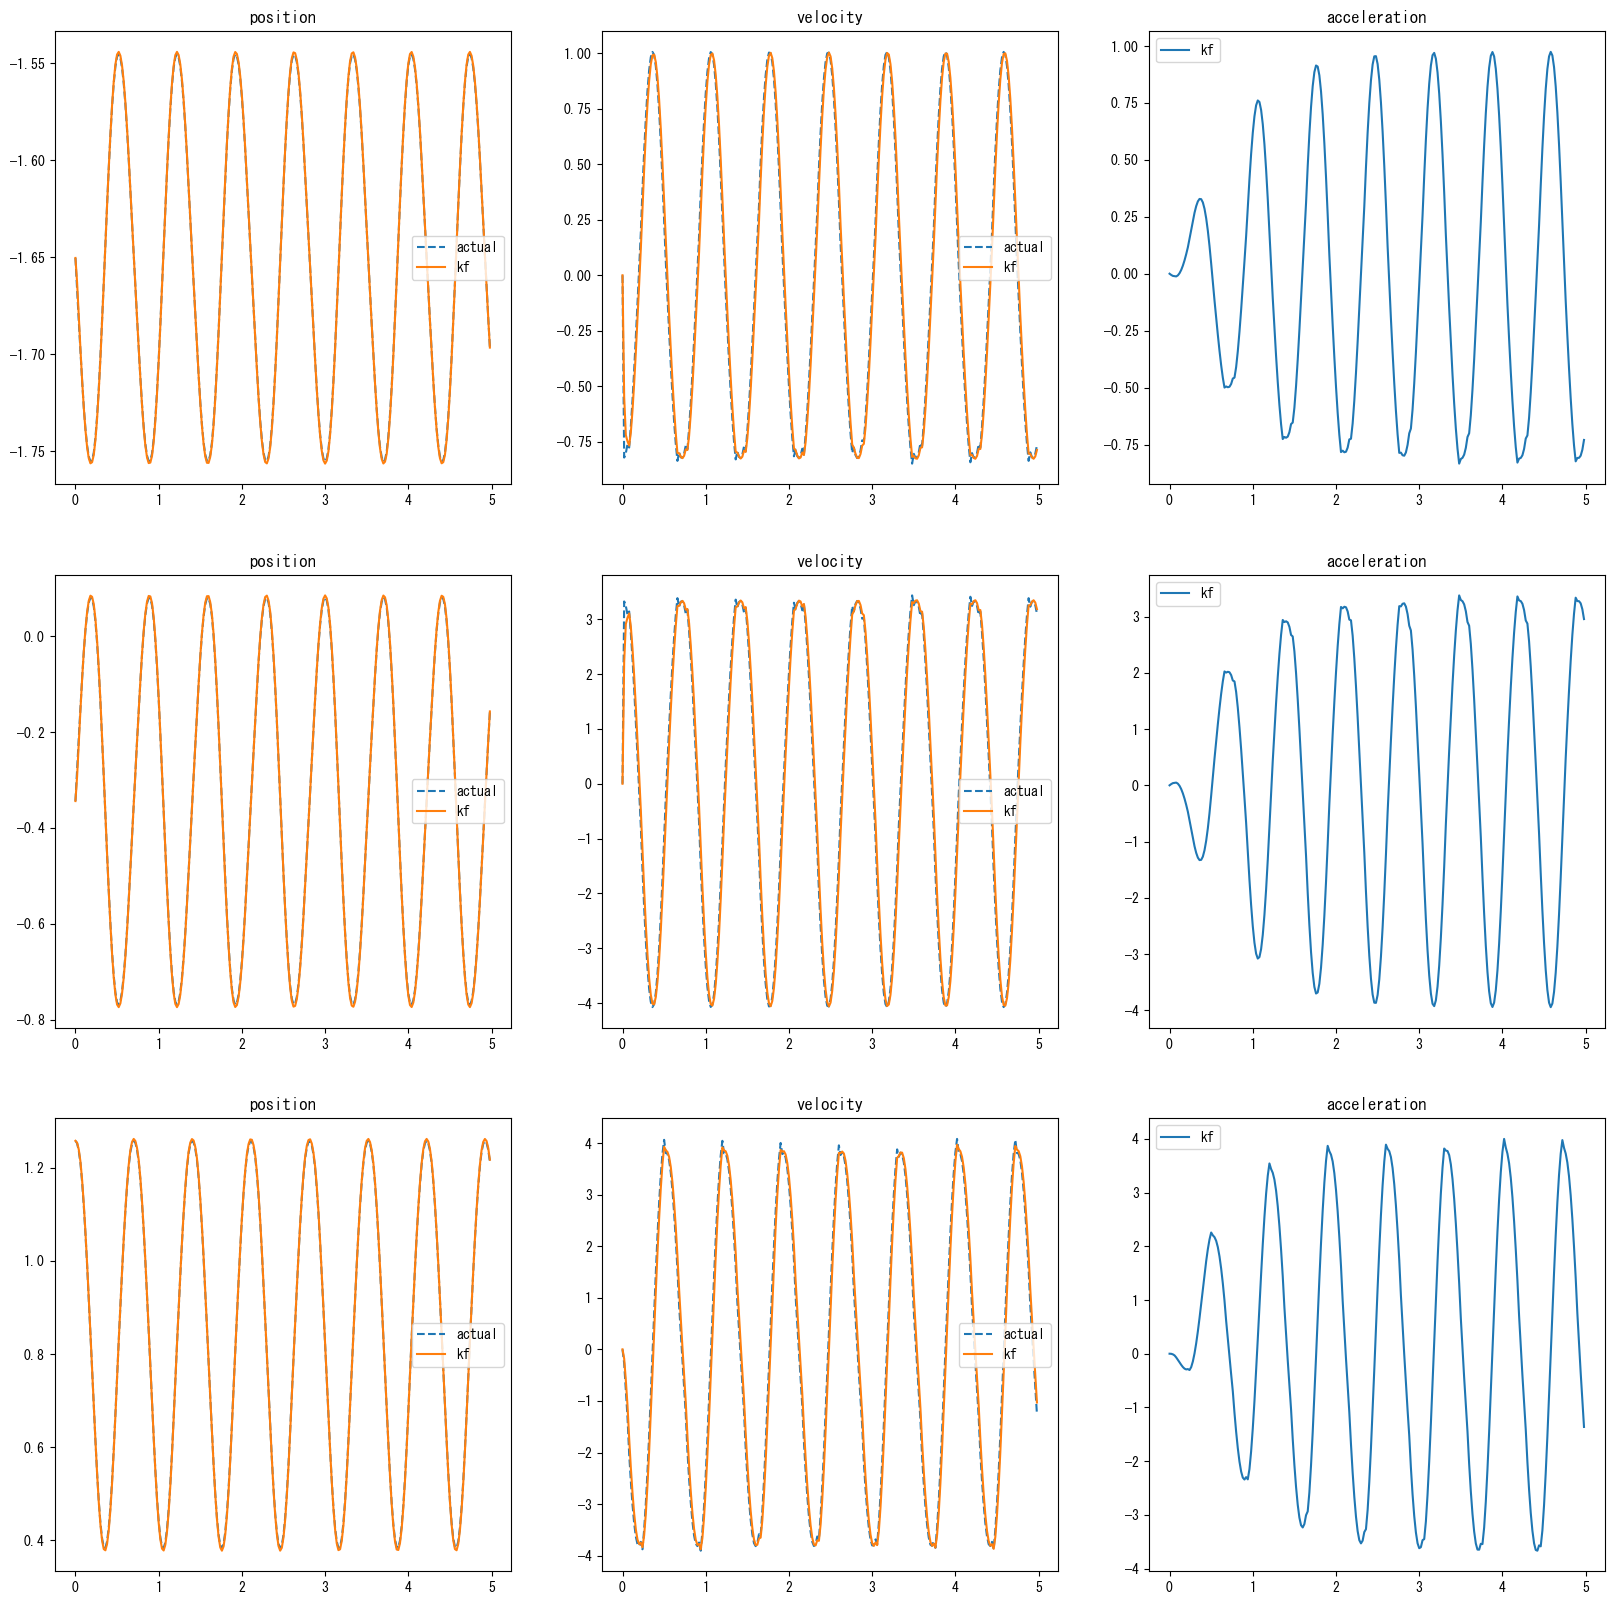

In [13]:
# HUman state
x_hum_pos_list = np.array(x_hum_pos_list)
x_hum_vel_list = np.array(x_hum_vel_list)
x_hum_acc_list = np.array(x_hum_acc_list)
x_hum_kf_pos_list = np.array(x_hum_kf_pos_list)
x_hum_kf_vel_list = np.array(x_hum_kf_vel_list)
x_hum_kf_acc_list = np.array(x_hum_kf_acc_list)

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i in range(3):
    ax[i, 0].plot(t_eval, x_hum_pos_list[:, i], linestyle="--", label="actual")
    ax[i, 0].plot(t_eval, x_hum_kf_pos_list[:, i], label="kf")
    ax[i, 0].legend()
    ax[i, 0].set_title(f"position")
    ax[i, 1].plot(t_eval, x_hum_vel_list[:, i], linestyle="--", label="actual")
    ax[i, 1].plot(t_eval, x_hum_kf_vel_list[:, i], label="kf")
    ax[i, 1].legend()
    ax[i, 1].set_title(f"velocity")
    # ax[i,2].plot(t_eval,x_hum_acc_list[:,i],linestyle="--"label="actual")
    ax[i, 2].plot(t_eval, x_hum_kf_acc_list[:, i], label="kf")
    ax[i, 2].legend()
    ax[i, 2].set_title(f"acceleration")
plt.savefig(os.path.join(saveDir, "human_kf_acc.png"))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\kawaw\\python\\mpc\\casadi_mpc_nyuumon\\images\\images\\rope_turning_ipopt.png'

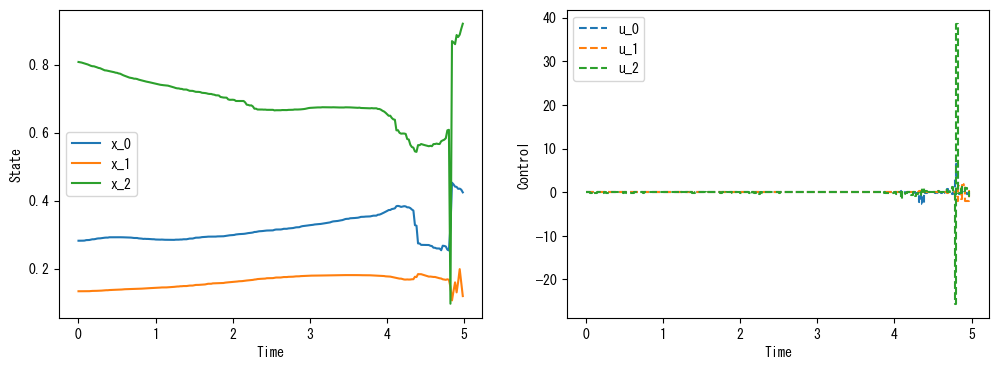

In [14]:
# Rope state
X.pop()


X = np.array(X).reshape(t_eval.size, mpc_controller.nx)


U = np.array(U).reshape(t_eval.size, mpc_controller.nu)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)


for k in range(3):

    plt.plot(t_eval, X[:, k], label=f"x_{k}")


plt.legend()


plt.xlabel("Time")


plt.ylabel("State")


plt.subplot(1, 2, 2)


for k in range(mpc_controller.nu):

    plt.step(t_eval, U[:, k], linestyle="--", label=f"u_{k}")


plt.legend()


plt.xlabel("Time")


plt.ylabel("Control")

savepath = os.path.join(saveDir, "images")
plt.savefig(os.path.join(savepath, "rope_turning_ipopt.png"))


plt.show()

# 計算時間

[*] solver: ipopt, elapsed time: 9.386402s


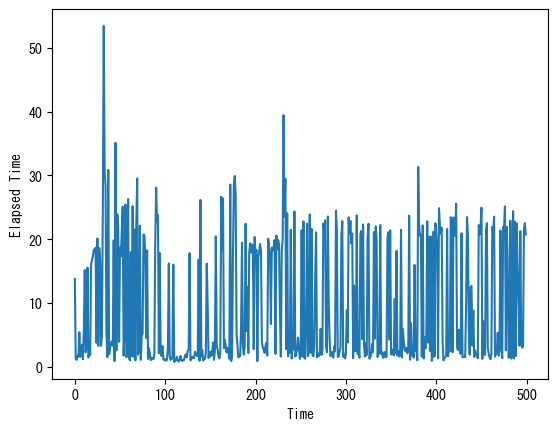

In [ ]:
Times_ipopt = np.array(Times_ipopt)
print(f"[*] solver: ipopt, elapsed time: {Times_ipopt.mean():1f}s")
plt.plot(Times_ipopt)
plt.xlabel("Time")
plt.ylabel("Elapsed Time")

plt.savefig("images/chap7_nlp_ipopt_time.png")
plt.show()

# アニメーションの作成

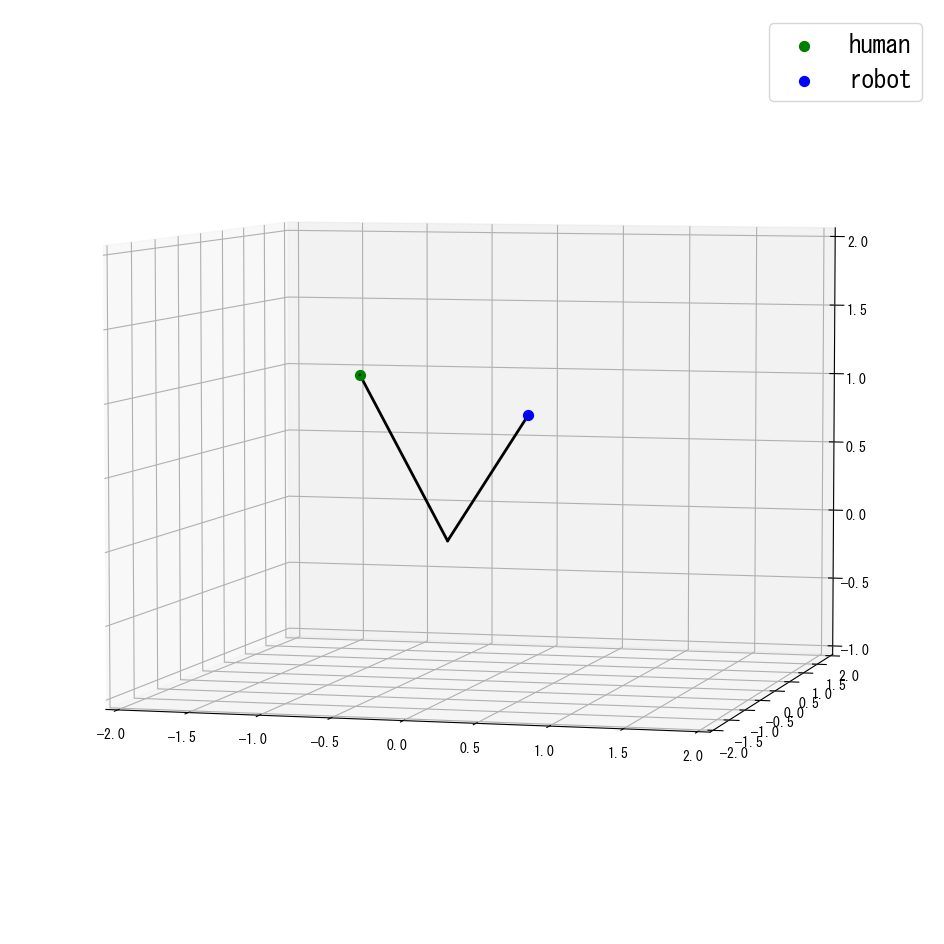

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
frames = np.arange(0, t_eval.size)
fps = 1 / mpc_controller.dt


def update_figure(i):
    x_lim_min = -2
    x_lim_max = 2
    y_lim_min = -2
    y_lim_max = 2
    z_lim_min = -1
    z_lim_max = 2
    u_scale = 3

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_zlim(z_lim_min, z_lim_max)
    ax.view_init(elev=5, azim=-75)

    points = X[i, : 3 * (mpc_controller.ns+1)]
    points_human = X[i, 3 * mpc_controller.ns: 3 * (mpc_controller.ns+1)]
    points = points.reshape(-1, 3)
    vel = U[i]

    ax.scatter(*points.T, color="black", s=2)
    ax.plot(*points.T, color="black", lw=2)
    #ax.plot(*points_human.T, color="red", lw=2)
    ax.quiver(*points[0], *vel / u_scale, length=1.0, normalize=False,color="blue")
    offset = 3 * (mpc_controller.ns+1)
    vel_human = X[i,offset+3*mpc_controller.ns:offset+3*(mpc_controller.ns+1)]
    ax.quiver(*points_human, *vel_human / u_scale, length=1.0, normalize=False,color="green")

    #left = np.zeros(3)
    # Fix: x_ref is already a numpy array, no need for .full()
    #right = x_ref.ravel()[3 * (ns - 1) : 3 * ns]
    point_robot = X[i,:3]
    #ax.scatter(*left, color="green", s=10)
    ax.scatter(*points_human, color="green", s=50,label="human")
    ax.scatter(*point_robot, color="blue", s=50,label="robot")
    ax.legend(fontsize=18)

ani = FuncAnimation(fig, update_figure, frames=frames)
savepath = os.path.join(currentDir, "images", "rope_turning.gif")
ani.save(savepath, writer="pillow", fps=int(fps))

# qrsqpの場合

In [ ]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0, 10]
t_eval = np.arange(*t_span, dt)
I = make_integrator()

x_init = make_x_init()
x0 = make_x0(x_init)

Times_qrsqp = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt, x0 = compute_optimal_control(S_qrsqp, x_current, x0)
    Times_qrsqp.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current, p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

TypeError: make_x_init() missing 3 required positional arguments: 'pose_eef', 'pos_human', and 'length_rope'

# 結果の可視化

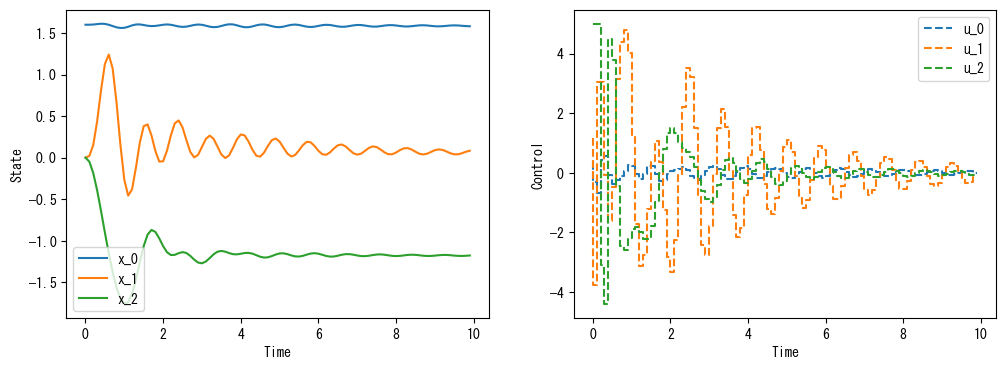

In [ ]:
X.pop()
X = np.array(X).reshape(t_eval.size, nx)
U = np.array(U).reshape(t_eval.size, nu)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(3):
    plt.plot(t_eval, X[:, k], label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1, 2, 2)
for k in range(nu):
    plt.step(t_eval, U[:, k], linestyle="--", label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap7_nlp_qrsqp.png")
plt.show()

# 計算時間

[*] solver: qrsqp, elapsed time: 0.087560s


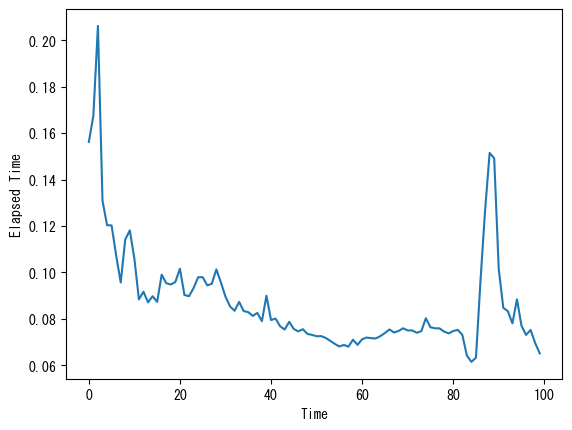

In [ ]:
Times_qrsqp = np.array(Times_qrsqp)
print(f"[*] solver: qrsqp, elapsed time: {Times_qrsqp.mean():1f}s")
plt.plot(Times_qrsqp)
plt.xlabel("Time")
plt.ylabel("Elapsed Time")

plt.savefig("images/chap7_nlp_qrsqp_time.png")
plt.show()

# 計算時間の比較

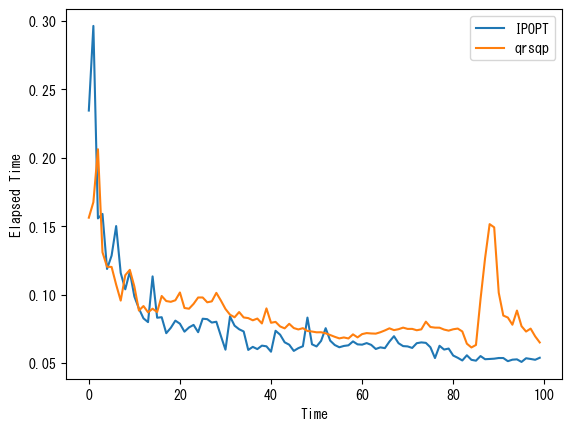

In [ ]:
plt.plot(Times_ipopt, label="IPOPT")
plt.plot(Times_qrsqp, label="qrsqp")
plt.xlabel("Time")
plt.ylabel("Elapsed Time")
plt.legend()

plt.savefig("images/chap7_nlp_time_comparison.png")
plt.show()

# IPOPT (初期値がランダム)

In [ ]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0, 10]
t_eval = np.arange(*t_span, dt)
I = make_integrator()

x_init = make_x_init()
x0 = casadi.DM(0.05 * np.random.normal(size=total))

Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt, x0 = compute_optimal_control(S_ipopt, x_current, x0)
    Times.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current, p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

# 結果の可視化

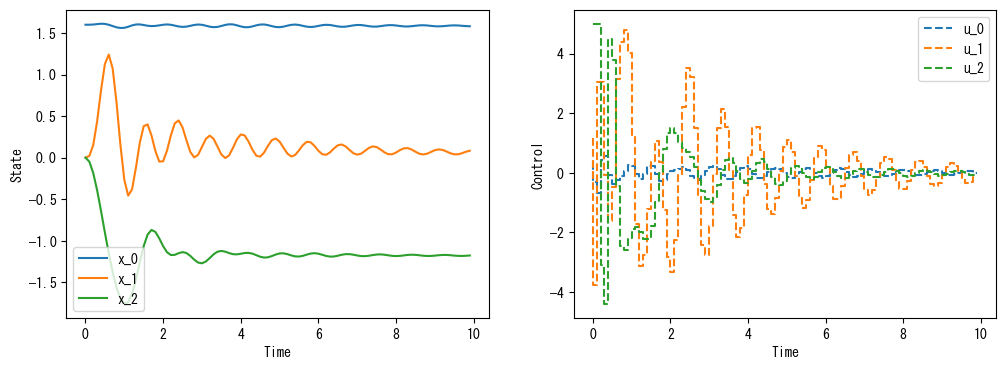

In [ ]:
X.pop()
X = np.array(X).reshape(t_eval.size, nx)
U = np.array(U).reshape(t_eval.size, nu)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(3):
    plt.plot(t_eval, X[:, k], label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1, 2, 2)
for k in range(nu):
    plt.step(t_eval, U[:, k], linestyle="--", label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap7_nlp_ipopt_without_init.png")
plt.show()

# 計算時間

[*] solver: ipopt, elapsed time: 0.099228s


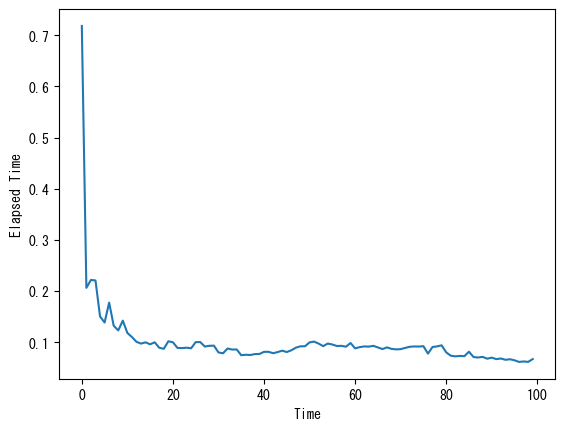

In [ ]:
Times = np.array(Times)
print(f"[*] solver: ipopt, elapsed time: {Times.mean():1f}s")
plt.plot(Times)
plt.xlabel("Time")
plt.ylabel("Elapsed Time")

plt.savefig("images/chap7_nlp_ipopt_time_without_init.png")
plt.show()

# qrsqp（初期値がランダム）

In [ ]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0, 10]
t_eval = np.arange(*t_span, dt)
I = make_integrator()

x_init = make_x_init()
x0 = casadi.DM(0.05 * np.random.normal(size=total))

Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt, x0 = compute_optimal_control(S_qrsqp, x_current, x0)
    Times.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current, p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size, nx)
U = np.array(U).reshape(t_eval.size, nu)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(3):
    plt.plot(t_eval, X[:, k], label=f"x_{k}")
plt.legend()

plt.subplot(1, 2, 2)
for k in range(nu):
    plt.step(t_eval, U[:, k], linestyle="--", label=f"u_{k}")
plt.legend()

plt.show()

Function qpsol (0x23c3a110010)
Input 0 (h): sparse: 627-by-627, 16563 nnz
 (0, 0) -> 28138.3
 (1, 0) -> -1685.45
 (2, 0) -> -536.813
 ...
 (624, 626) -> 8.85934e-314
 (625, 626) -> 3.43841e-314
 (626, 626) -> 0.05
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4.3799, 0.0200849, 0.013273, -0.0294259, 0.419588, 0.0495142, 0.459484, 56.2863, 0.42488, 0.258665, -0.30831, -0.055038, 0.190656, 0.864138, -0.229121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5.74891, -2.85392, 2.16547, 8.00064, -1.33744, -6.46264, 1.37325, 57.8365, 0.00117796, 7.21703, -3.57416, -6.92585, -3.44895, 25.0807, -28.1352, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6.86825, -2.01512, 3.02885, -3.21869, 4.25513, -19.3456, -0.515537, 53.5018, 8.62726, 13.742, 2.6579, -27.5697, 11.1404, 45.898, -45.9766, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -7.82227, -3.18445, 4.04628, -6.13987, -0.259574, -25.3445, 22.2384, 80.1771, -11.2228, -17.515, -15.6578, -27.1886, -34.522, 46.8546, -5.22258, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -9.06551

RuntimeError: Error in Function::call for 'S' [Qrsqp] at .../casadi/core/function.cpp:1458:
Error in Function::call for 'S' [Qrsqp] at .../casadi/core/function.cpp:362:
Error in Function::operator() for 'qpsol' [Qrqp] at .../casadi/core/function.cpp:1539:
.../casadi/core/conic.cpp:559: conic process failed. Set 'error_on_fail' option to false to ignore this error.